# Offensive Word Classification



# Motivation

With the rise of social media in our everyday life and the lack of filters for offensive words, we are susceptible to running into offensive words every now and then. This may not be an issue to an adult, but for an underage individual this may not be an appropriate environment to be in. With ideas gathered from multiple papers, our group would like to implement an algorithm that will aid in minimizing offensive words with noise in comments for the term project. In natural language processing, this task falls under what is called a classification task. Moreover, the aspects of this problem that we plan to work on are both in attempting to improve the accuracy of classification and interpret-ability of offensive words with noise in online comments. Offensive words with noise were chosen because malicious users may find clever ways around moderation by using variations of spellings or character replacement for offensive words.

# Approach
For multi-class classification, our approach uses GloVe word embeddings for the embedding layer of our denoising model. Moreover, our denoising model utilizes the recurrent neural networks architecture known as a bi-directional LSTM model.
![alt text](https://camo.githubusercontent.com/7c17fdb1a2a5f7d0b896c44aefe7490c47d23bfa/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f696e63646a727575347839323038332f6269646972656374696f6e616c5f6c6f6e675f73686f72742d7465726d5f6d656d6f72792e706e673f7261773d31)
To add noise to the test data we used optical character recognition (OCR) error. Specifically, the OCRAug function from the nlpaug package. OCRAug replaces target characters with characters in a predefined mapping table.
<br><br>Example of clean vs noisy sentence
*   Clean: "The quick brown fox jumped over the lazy dog"
*   Noisy: "The qoick 6rown f0x jomped ovek the la2y d0g"
To deal with the noise in the training data we used the same methodologies that we learned from homework three (robust phrasal chunking). We generated character level representation of a word using the following method:
1.   Create a one-hot vector v1 for the first character of the word.
2.   Create a vector v2 where the index of a character has the count of that character in the word.
3.   Create a one-hot vector v3 for the last character of the word.

We concatenated 300-dim one-hot vector with the 50-dim embedding matrix, which was applied to our denoising model with two epochs. As an optimizer, we used a stochastic gradient descent optimizer (SGD)

# Data
The data used throughout the our project includes the following:

- [Jigsaw toxic comment classification challenge (Data)](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)

  - The training dataset provided by Jigsaw contains 160k of Wikipedia comments classified as toxic, severe_toxic, obscene, threat, insult, or identity_hate via crowdsourcing
The test set contains 153k comments

Here are examples of the different labels from the data set:

In [0]:
import random
for label in list_classes:
    label_df = train[train[label]==1].reset_index(drop = 1)
    print('\n' + label + ' - comment sample :')
    print(label_df.loc[random.randint(0, len(label_df)-1), 'comment_text'])
    print('\n' + '-'*50)


toxic - comment sample :
DMacks and DavidWS 3 words, GO FUCK YOURSELVES !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

--------------------------------------------------

severe_toxic - comment sample :
Suck my fattie you cunt piece of shit. Blow your warning out your ass.

--------------------------------------------------

obscene - comment sample :
u guys are fucking morrons

--------------------------------------------------

threat - comment sample :
quick thing mate 

Give me a couple of reasons NOT to kill you plz. btw this is a shared IP adress on a school computer so don't even bother responding,

--------------------------------------------------

insult - comment sample :
SuperMarioMan is a fuckass!
You are a stupid motherf**ker! Ravioli DOES INDEED cause diarrhea!  Look it up!!!!!  HEED MY WARNING!!!!!!!!!!!!!!!!!!!

--------------------------------------------------

identity_hate - comment sample :
THE FUKKING RETARDO RACISTO KANUCK

--------------------------------------------------


-  Augmented test data can be found in a file in our gitlab named test_with_augmentation.csv which is under the **/project/input/jigsaw-toxic-comment-classification-challenge** directory 


- [GloVe pre-trained word vectors](http://nlp.stanford.edu/data/glove.6B.zip)

# Code

Our baseline code is based on this [kernel](https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout), we found on kaggle. 

We also used a numpy implementation of the "character level representation of the word" method used in our __Homework 3: Robust Phrasal Chunking__ solution:

In [0]:
def char_level_rep(word):
  """
  Generate the character level representation vectors for an input word
  :param word: Word to get character level representation vectors generated
  """
  # find the 300 dimensions for each word in a sentence
  chars = string.printable
  # Create vectors
  v1 = np.zeros(len(chars))
  v2 = np.zeros(len(chars))
  v3 = np.zeros(len(chars))

  for w in word:
      for i, c in enumerate(chars):
          if w == c:
              # Create vector where the index of a character has the count of that character in the word
              v2[i] = v2[i] + 1

  for i, char in enumerate(chars):
      if word[0] == char:
          # Create the one-hot vector for the first character of the word
          v1[i] = 1
      if word[len(word) - 1] == char:
          # Create a one-hot vector for the last character of the word
          v3[i] = 1

  # 300 dimentions for each word in a sentence
  vector_rep = np.concatenate((v1, v2, v3))  # 300

  return vector_rep  # 300

# Experimental Setup

__Important Notice__: Our model has been run and tested on google colab ( The only extra required package is the "nlpaug")

All the accuracy measurements are done using Kaggle’s mean column-wise ROC AUC metric.


We used a simple Bidirectional LSTM Model with two fully connected layers: 

In [0]:
model = Sequential()

model.add(Embedding(max_features, embed_size, weights=[embedding_matrix],input_shape=(maxlen,)))
model.add(Bidirectional(CuDNNLSTM(50, return_sequences=True))) # For running on GPU
model.add(GlobalMaxPool1D())
model.add(Dropout(0.15))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.15))
model.add(Dense(6, activation="sigmoid"))

sgd_opt = optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False)

model.compile(loss='binary_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 350)          7000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 100)          160800    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

The denoising weights added to our training model improved our accuracy by 2%

Since the training accuracy was really high (96.36% after only 2 epochs), The model was overfitting the training set so we added  two dropout layers (each with ratings of 0.15). This improved our accuracy score by about 0.5%.

  

##### Denoising Implementation:
- While iterating through the word index to create the embedding_matrix (i.e. matrix containing the weights used for our model's input layer):
  1. Run that word through the __augment_text_ocr__ function to get the noisy representation of the word (e.g. "bitch" ==> "'6itch'")
  3. Give the noisy word to __char_level_rep__ function to get the 300-dimension one-hot vector
  3. Concatenate the one_hot vectors to GloVe embeddings to create the embedding_matrix)

-  Adjust the first layer of the model based on the new dimension size 



# Results


- Playing around with hyperparameters:
  - After a lot of trial and error, the best learning rate we found was 0.01. Larger learning rate would lead to the model not converging
  - Even though the industry standard optimizer is apparently "adam", switching to stochastic gradient descent (i.e. "SGD") improved our accuracy by about 0.5% (Having said that, we suspect that this might be an accidental improvement on our the prediction accuracy)
  

# Analysis of the Results

Yes we were able to improve the baseline from 68.5% to 71.5%.

The following code/heatmap shows the correlation between each of the 6 labels and how likely they would occur in the same comment together. For instance, labels "obscene" and "insult" are often seen together; whereas, "identity_hate" and "threat" rarely happen in the same comment.

(6.0, 0.0)

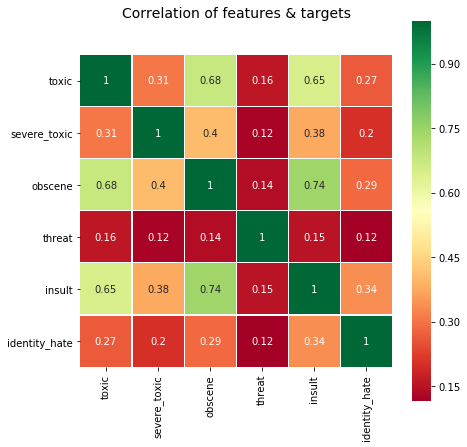

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
data = train[list_classes]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))

plt.title('Correlation of features & targets',y=1.1,size=14)

ax = sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap='RdYlGn',
           linecolor='white',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


# Future Work


The original plan for this project was to use a different data set with noise on the baseline model than the data set provided. We found a series of data sets that we could have used. However, the data sets were not labelled with the same labels the kaggle data set had. Which meant that we would have to manually add the labels to the new data set. It would have been too time consuming to complete this task this semester. We decided that this could be a  
If we had more time, We would create a different "denoising" model that cleans up the test set at which point we could feed the clean test set into our model trained on clean train sets.